In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5994972
drwx------ 3 root root       4096 May  4 19:39 gdrive
drwx------ 3 root root       4096 May  4 19:41 models
drwxr-xr-x 1 root root       4096 Apr 29 16:32 sample_data
drwx------ 3 root root       4096 May  4 19:41 tools
-rw------- 1 root root  818509952 May  4 19:39 X_test.npy
-rw------- 1 root root 2619205760 May  4 19:40 X_train.npy
-rw------- 1 root root  654815360 May  4 19:40 X_val.npy
-rw------- 1 root root  409255040 May  4 19:40 y_test.n

In [ ]:
!cp gdrive/My\ Drive/12/weights5 weights

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import tools._my_tools as mt
import tools._torch_tools as tt
import models.loss as lo
import numpy as np

import gc

data_folder = "dataset_interpolation/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)

Device is cuda:0


In [2]:
X_val, y_val =  mt.loadData(data_folder,val=True,typeF='float16',channels_last=False)

Loading dataset_interpolation/X_val.npy
Loading dataset_interpolation/y_val.npy


In [2]:
X_train, y_train, X_val, y_val = mt.loadData(data_folder,train=True,val=True,typeF='float16',channels_last=False)

Loading dataset_interpolation/X_train.npy
Loading dataset_interpolation/y_train.npy
Loading dataset_interpolation/X_val.npy
Loading dataset_interpolation/y_val.npy


In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
#             nn.ConvTranspose2d(in_channels,in_channels,(2,2),(2,2)),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), nn.PReLU()
        )

In [41]:
model = Model()
model.load_state_dict(torch.load("12/weights50.pth"))
training = tt.Training(model, device, X_train, y_train, X_val, y_val, loss_function=nn.L1Loss())
training.history = mt.fromCSV("12/history.csv")

In [5]:
try:
    training.fit(32,5,val=True,save="12/",save_off=45)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[46](4440/4440): Loss: 0.0180	ETA 0:00:00	Epoch Loss: 0.0152
Epoch[46] finished in 0:05:13 with loss 0.015239310648653085
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0159
Validation loss = 0.0159

----------------------------

===> Epoch[47](4440/4440): Loss: 0.0176	ETA 0:00:00	Epoch Loss: 0.0152
Epoch[47] finished in 0:05:13 with loss 0.015169689211960848
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0159
Validation loss = 0.0159

----------------------------

===> Epoch[48](4440/4440): Loss: 0.0176	ETA 0:00:00	Epoch Loss: 0.0151
Epoch[48] finished in 0:05:14 with loss 0.015119923831190209
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0161
Validation loss = 0.0161

----------------------------

===> Epoch[49](4440/4440): Loss: 0.0175	ETA 0:00:00	Epoch Loss: 0.0151
Epoch[49] finished in 0:05:14 with loss 0.0151086225189050

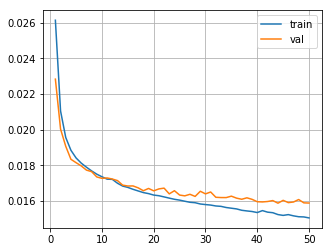

In [45]:
mt.plotHistory(training.history,save="12/history.png",size=(5,4))

In [7]:
mt.toCSV("12/history.csv",training.history)

## Perceptual Loss Experiments

In [15]:
import models.loss as lo

def tryVGG(out_f, layer):
    model = Model()
    model.load_state_dict(torch.load("12/weights50.pth"))
    training = tt.Training(model,device,X_train, y_train, X_val, y_val, loss_function=lo.VggLoss(output_layer=layer))
    try:
        training.fit(32,5,val=True,save=out_f)
        mt.toCSV(out_f+"history.csv",training.history)
        mt.plotHistory(training.history)
    except KeyboardInterrupt:
        print("\n\nFinished training.")

#### relu2_2



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0280	ETA 0:00:00	Epoch Loss: 0.0273
Epoch[1] finished in 0:06:34 with loss 0.027279888203803886
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0272
Validation loss = 0.0272

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0278	ETA 0:00:00	Epoch Loss: 0.0266
Epoch[2] finished in 0:06:35 with loss 0.026640767106987737
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0269
Validation loss = 0.0269

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0277	ETA 0:00:00	Epoch Loss: 0.0265
Epoch[3] finished in 0:06:35 with loss 0.026475755326651237
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0268
Validation loss = 0.0268

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0275	ETA 0:00:00	Epoch Loss: 0.0264
Epoch[4] finished in 0:06:34 with loss 0.026351054915151485
Valid

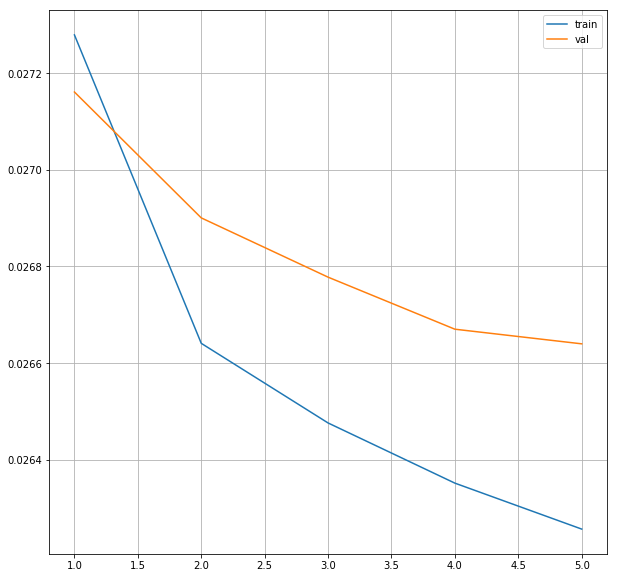

In [16]:
out_f = "12/relu2_2/"
tryVGG(out_f,-18)

#### relu3_4



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0233	ETA 0:00:00	Epoch Loss: 0.0233
Epoch[1] finished in 0:06:51 with loss 0.023319524527854612
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0228
Validation loss = 0.0228

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0234	ETA 0:00:00	Epoch Loss: 0.0226
Epoch[2] finished in 0:06:51 with loss 0.022589617646676864
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0227
Validation loss = 0.0227

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0232	ETA 0:00:00	Epoch Loss: 0.0224
Epoch[3] finished in 0:06:51 with loss 0.022385224337932896
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0224
Validation loss = 0.0224

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0232	ETA 0:00:00	Epoch Loss: 0.0222
Epoch[4] finished in 0:06:50 with loss 0.022239981900464306
Valid

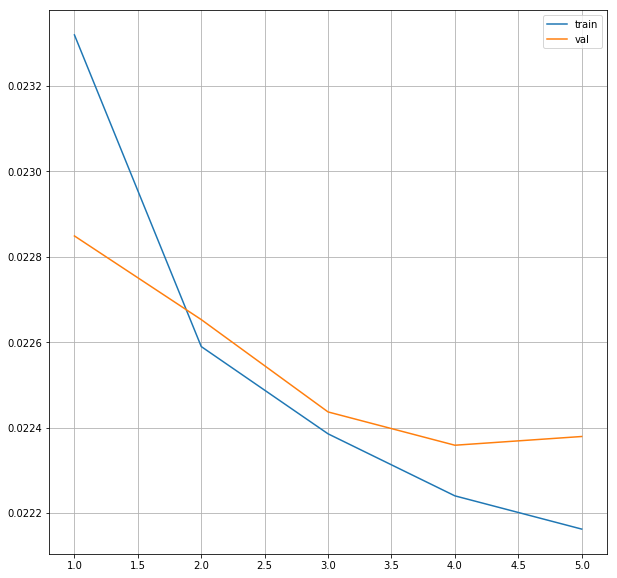

In [17]:
out_f = "12/relu3_4/"
tryVGG(out_f,-14)

#### relu4_4



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0108	ETA 0:00:00	Epoch Loss: 0.0109
Epoch[1] finished in 0:07:08 with loss 0.010938642428650915
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0105
Validation loss = 0.0105

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0109	ETA 0:00:00	Epoch Loss: 0.0104
Epoch[2] finished in 0:07:09 with loss 0.010409473316106308
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0103
Validation loss = 0.0103

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0109	ETA 0:00:00	Epoch Loss: 0.0103
Epoch[3] finished in 0:07:10 with loss 0.010295552740855193
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0103
Validation loss = 0.0103

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0108	ETA 0:00:00	Epoch Loss: 0.0102
Epoch[4] finished in 0:07:10 with loss 0.0102224513800261
Validat

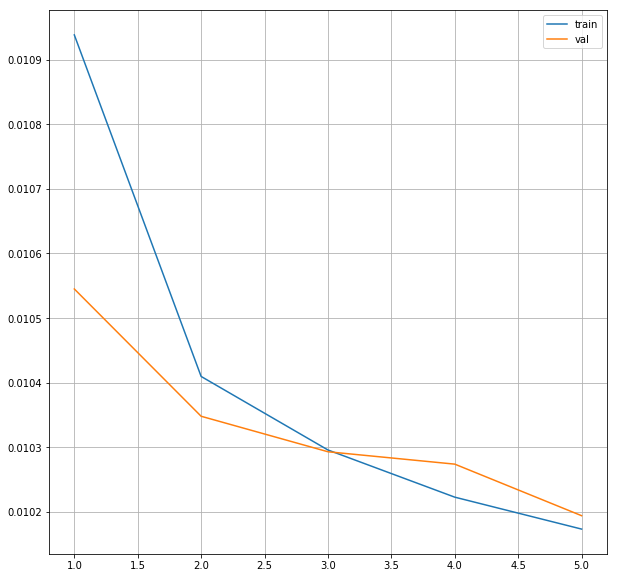

In [18]:
out_f = "12/relu4_4/"
tryVGG(out_f,-10)

#### relu5_4



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0108	ETA 0:00:00	Epoch Loss: 0.0109
Epoch[1] finished in 0:07:17 with loss 0.01090671727727461
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0103
Validation loss = 0.0103

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0105	ETA 0:00:00	Epoch Loss: 0.0102
Epoch[2] finished in 0:07:18 with loss 0.0102382524182332
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0101
Validation loss = 0.0101

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0105	ETA 0:00:00	Epoch Loss: 0.0101
Epoch[3] finished in 0:07:17 with loss 0.010074448005531218
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0099
Validation loss = 0.0099

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0103	ETA 0:00:00	Epoch Loss: 0.0100
Epoch[4] finished in 0:07:18 with loss 0.009956669074961462
Validati

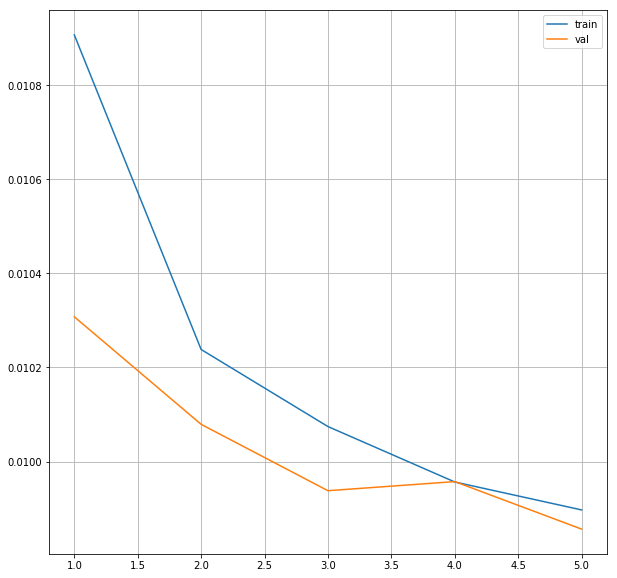

In [19]:
out_f = "12/relu5_4/"
tryVGG(out_f,-6)

### VGG19 based losses evaluation

In [15]:
import models.loss as lo

def validateSSIM(in_weights):
    model = Model()
    model.load_state_dict(torch.load(in_weights))
    validating = tt.Training(model,device,X_val, y_val, X_val, y_val, loss_function=lo.SSIMLoss())
   
    return validating.validate(1)

In [ ]:
l = ["12/relu2_2/weights05.pth",
    "12/relu3_4/weights05.pth",
    "12/relu4_4/weights05.pth",
    "12/relu5_4/weights05.pth",]
out = []

for w in l:
    out.append(validateSSIM(w))
    mt.toCSV("12/relu.csv",{"name":l,"ssim":out})

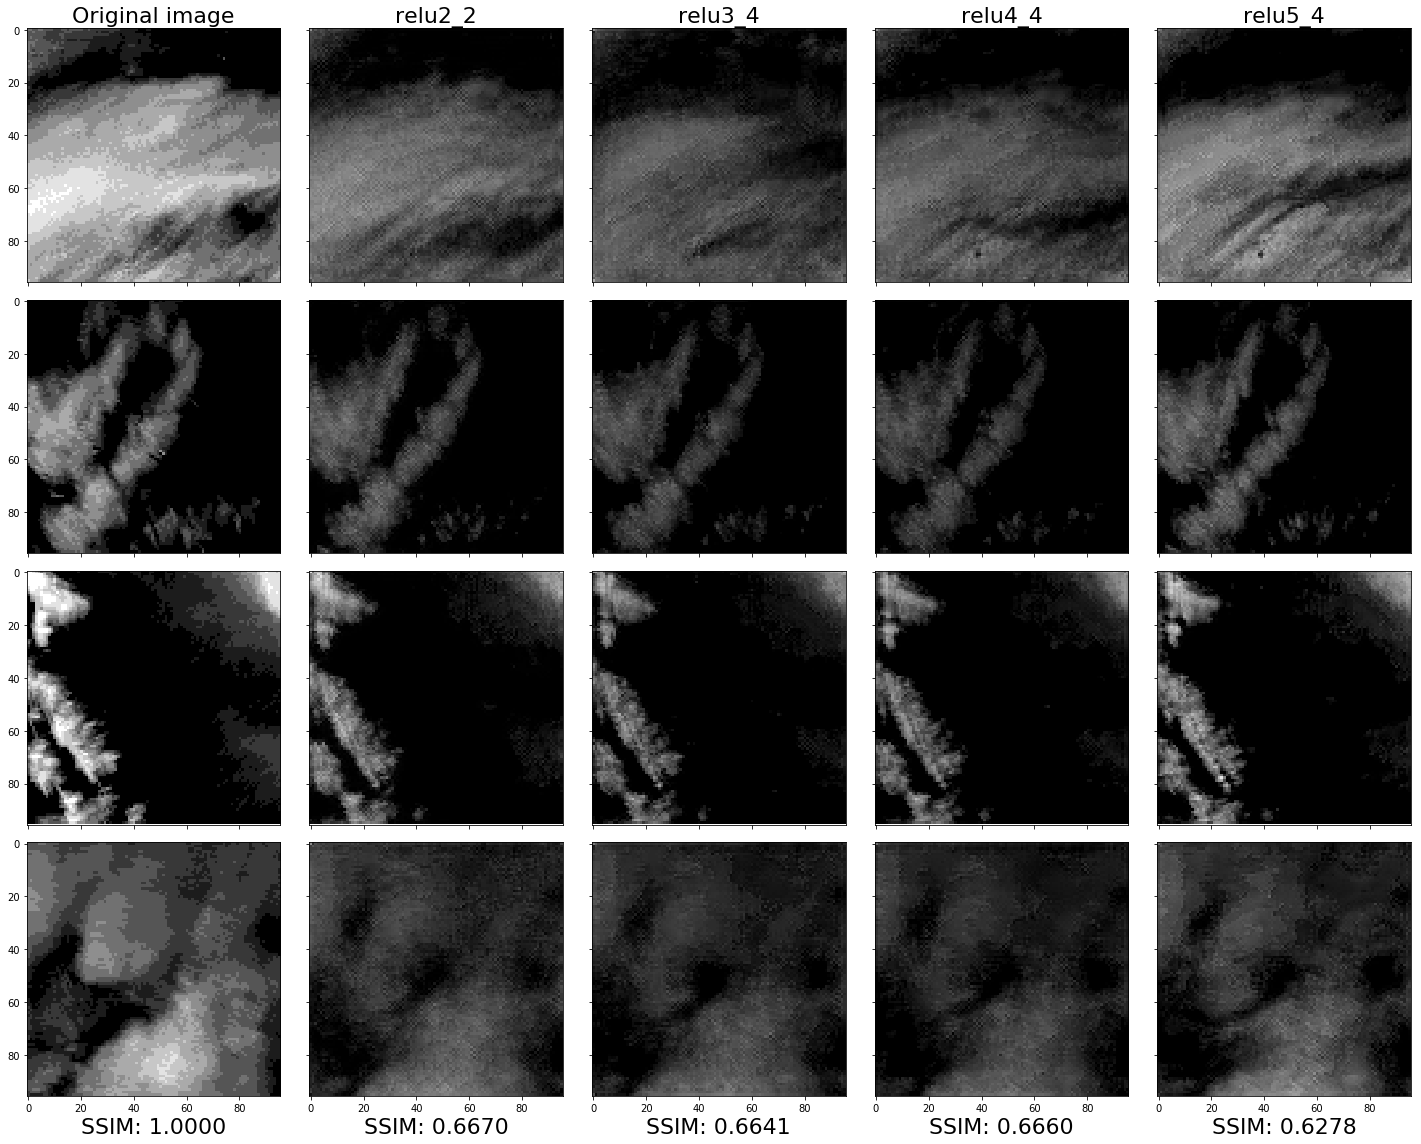

In [40]:
model = Model()
# Full showcase is [13,38,42,75,82]
X = np.take(X_val,[13,38,42,82],axis=0)
Y = np.take(y_val,[13,38,42,82],axis=0)
out = []

dic = mt.fromCSV("12/relu.csv")

for name in dic['name']:
    model.load_state_dict(torch.load("12/" + name + "/weights05.pth"))
    out.append( model( torch.tensor(X, dtype=torch.float) ).cpu().detach().numpy() )

draw = [Y,*out]
names = ['Original image',*dic['name']]
ssims = [1,*dic['ssim']]

fig, axes = plt.subplots(nrows=len(X), ncols=5, figsize=(20, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()

# label = 'Average validation dataset SSIM: {:.2f}'
label = 'SSIM: {:.4f}'

for i in range(len(X)):
    for j in range(5):
            ax[i*5+j].imshow(draw[j][i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
            if i == len(X)-1:
                ax[i*5+j].set_xlabel(label.format(ssims[j]),fontsize=22)
            if i == 0 :
                ax[i*5+j].set_title(names[j],fontsize=22)

plt.tight_layout()
# plt.show()
plt.savefig("12/vgg_res.png")

### Combined Losses

In [11]:
import models.loss as lo

def tryComb(out_f, factor, layer):
    model = Model()
    model.load_state_dict(torch.load("12/weights50.pth"))
    training = tt.Training(model,device,X_train, y_train, X_val, y_val, loss_function=lo.CombinedLoss(layer,factor))
    try:
        training.fit(32,5,val=True,save=out_f)
        mt.toCSV(out_f+"history.csv",training.history)
        mt.plotHistory(training.history)
    except KeyboardInterrupt:
        print("\n\nFinished training.")

#### 1x10e-5



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0333	ETA 0:00:00	Epoch Loss: 0.0303
Epoch[1] finished in 0:06:37 with loss 0.030266010545210928
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0310
Validation loss = 0.0310

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0333	ETA 0:00:00	Epoch Loss: 0.0299
Epoch[2] finished in 0:06:49 with loss 0.0299499438127486
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0309
Validation loss = 0.0309

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0333	ETA 0:00:00	Epoch Loss: 0.0298
Epoch[3] finished in 0:06:41 with loss 0.02984496386772072
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0309
Validation loss = 0.0309

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0333	ETA 0:00:00	Epoch Loss: 0.0298
Epoch[4] finished in 0:06:38 with loss 0.02976196043671587
Validatin

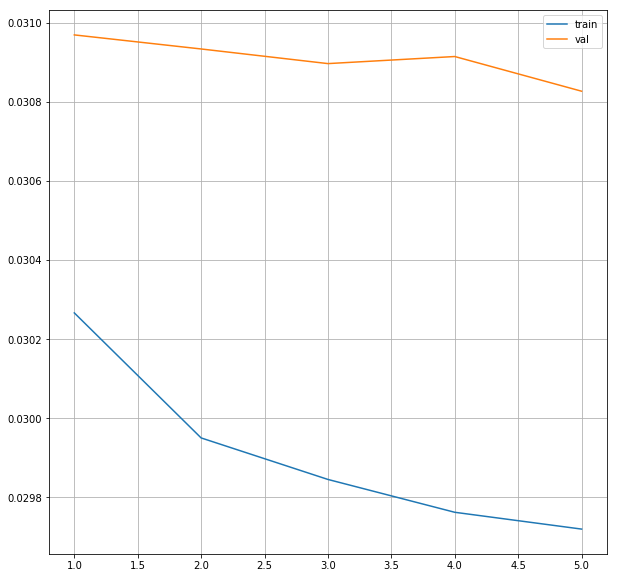

In [12]:
out_f = "12/comb1/"
tryComb(out_f,0.00001,-18)

2x10e-5



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0479	ETA 0:00:00	Epoch Loss: 0.0445
Epoch[1] finished in 0:06:37 with loss 0.04451115370585441
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0454
Validation loss = 0.0454

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0473	ETA 0:00:00	Epoch Loss: 0.0439
Epoch[2] finished in 0:06:37 with loss 0.043933174586309506
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0450
Validation loss = 0.0450

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0475	ETA 0:00:00	Epoch Loss: 0.0437
Epoch[3] finished in 0:06:38 with loss 0.04372640780366219
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0449
Validation loss = 0.0449

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0474	ETA 0:00:00	Epoch Loss: 0.0436
Epoch[4] finished in 0:06:39 with loss 0.043603169527911656
Validat

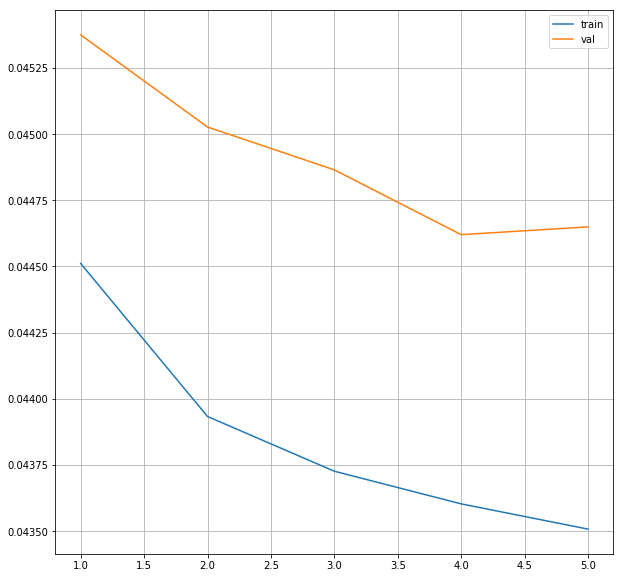

In [14]:
out_f = "12/comb2/"
tryComb(out_f,0.00002,-18)

3x10e-5



====== TRAINING ======
===> Epoch[1](4440/4440): Loss: 0.0629	ETA 0:00:00	Epoch Loss: 0.0586
Epoch[1] finished in 0:06:38 with loss 0.05856008340713677
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0593
Validation loss = 0.0593

----------------------------

===> Epoch[2](4440/4440): Loss: 0.0619	ETA 0:00:00	Epoch Loss: 0.0577
Epoch[2] finished in 0:06:38 with loss 0.057703232072998545
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0588
Validation loss = 0.0588

----------------------------

===> Epoch[3](4440/4440): Loss: 0.0619	ETA 0:00:00	Epoch Loss: 0.0574
Epoch[3] finished in 0:06:37 with loss 0.057396847931752065
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0590
Validation loss = 0.0590

----------------------------

===> Epoch[4](4440/4440): Loss: 0.0614	ETA 0:00:00	Epoch Loss: 0.0572
Epoch[4] finished in 0:06:38 with loss 0.05720549787956852
Validat

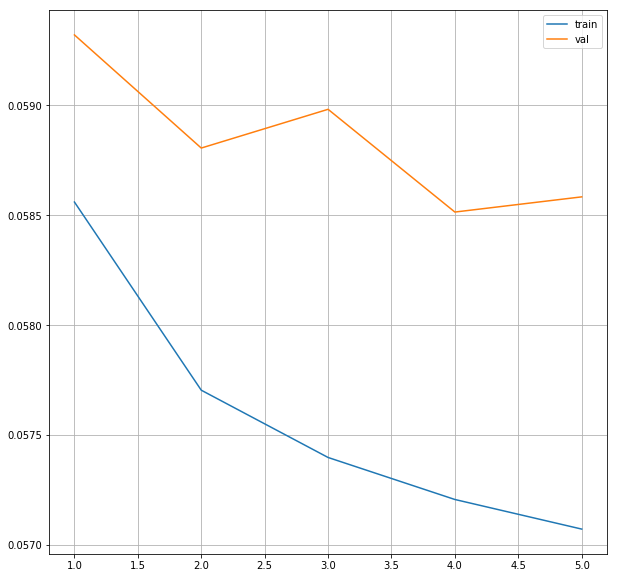

In [13]:
out_f = "12/comb3/"
tryComb(out_f,0.00003,-18)

### Combined Loss validation

In [16]:
l = ["12/comb1/weights05.pth",
    "12/comb2/weights05.pth",
    "12/comb3/weights05.pth"]
out = []

for w in l:
    print(w)
    out.append(validateSSIM(w))
    mt.toCSV("12/comb.csv",{"name":l,"ssim":out})

12/comb1/weights05.pth
Validating on 35526 samples.
===> Validating (35526/35526):	ETA 0:00:00	Validation Loss: 0.7525
Validation loss = 0.7525
12/comb2/weights05.pth
Validating on 35526 samples.
===> Validating (35526/35526):	ETA 0:00:00	Validation Loss: 0.7463
Validation loss = 0.7463
12/comb3/weights05.pth
Validating on 35526 samples.
===> Validating (35526/35526):	ETA 0:00:00	Validation Loss: 0.7453
Validation loss = 0.7453


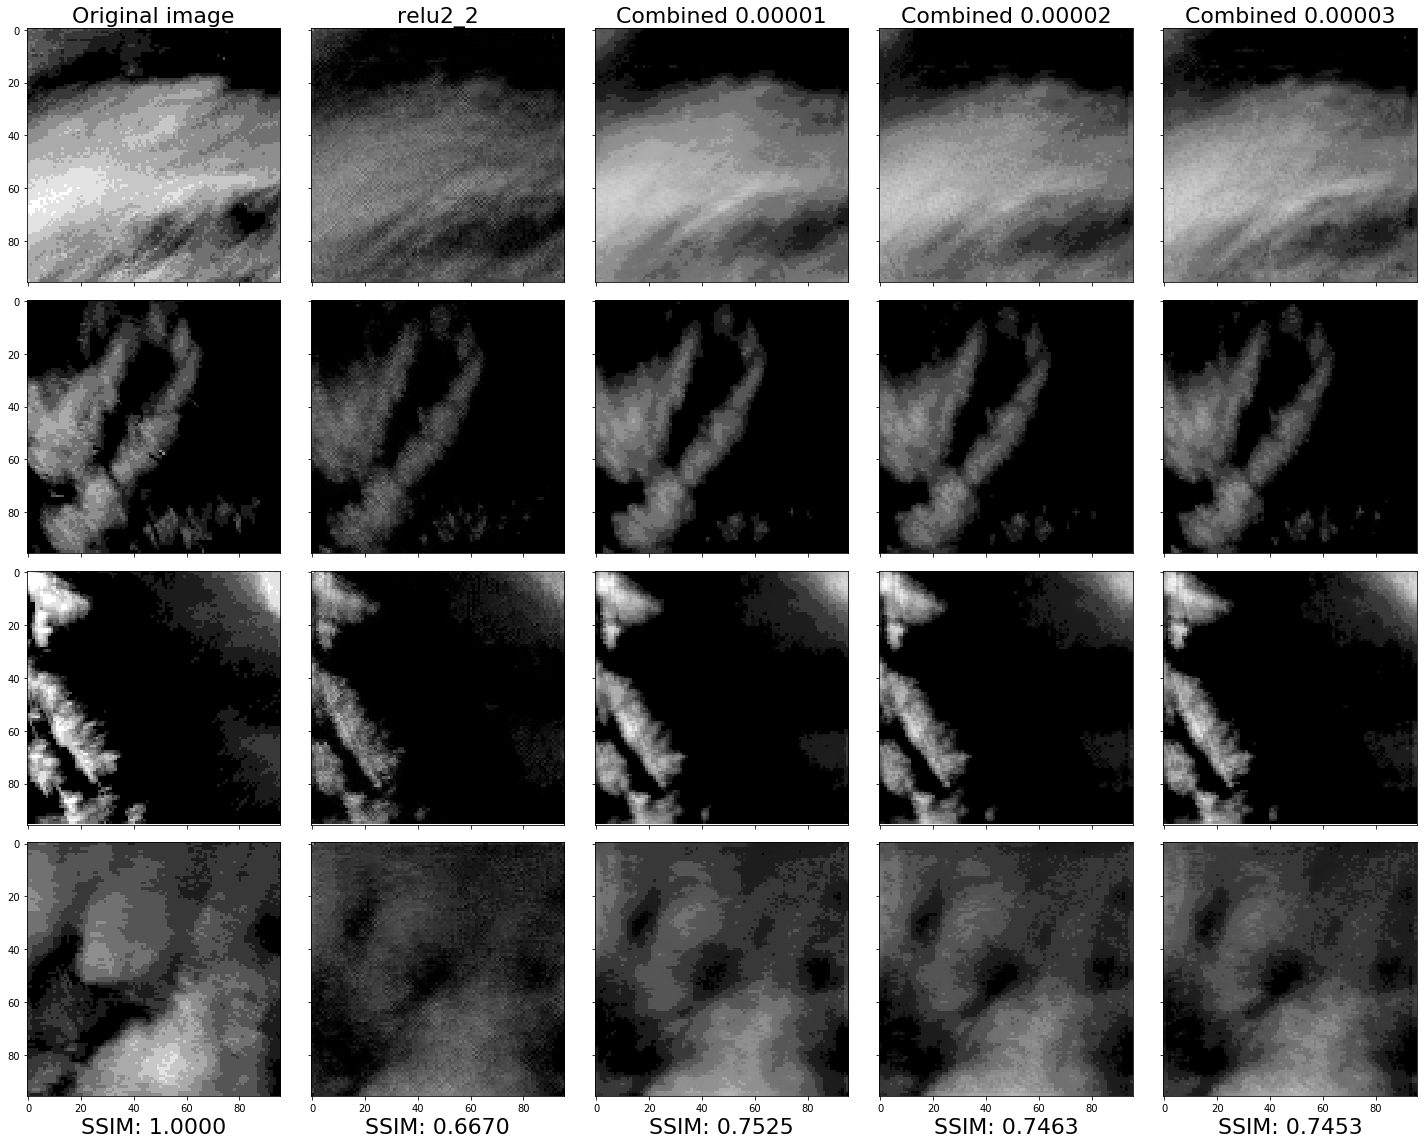

In [37]:
import matplotlib.pyplot as plt

model = Model()
# Full showcase is [13,38,42,75,82]
X = np.take(X_val,[13,38,42,82],axis=0)
Y = np.take(y_val,[13,38,42,82],axis=0)
out = []

dic = mt.fromCSV("12/comb.csv")

# Get results of pure relu2_2
model.load_state_dict(torch.load("12/relu2_2/weights05.pth"))
out.append( model( torch.tensor(X, dtype=torch.float) ).cpu().detach().numpy() )

# Get results of combined
for name in dic['name']:
    model.load_state_dict(torch.load(name))#"12/" + name + "/weights05.pth"))
    out.append( model( torch.tensor(X, dtype=torch.float) ).cpu().detach().numpy() )

draw = [Y,*out]
names = ['Original image','relu2_2','Combined 0.00001','Combined 0.00002','Combined 0.00003']
ssims = [1,0.6670,*dic['ssim']]

COL = 5
fig, axes = plt.subplots(nrows=len(X), ncols=COL, figsize=(20, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()

# label = 'Average validation dataset SSIM: {:.4f}'
label = 'SSIM: {:.4f}'

for i in range(len(X)):
    for j in range(COL):
            ax[i*COL+j].imshow(draw[j][i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
            if i == len(X)-1:
                ax[i*COL+j].set_xlabel(label.format(ssims[j]),fontsize=22)
            if i == 0 :
                ax[i*COL+j].set_title(names[j],fontsize=22)

plt.tight_layout()
# plt.show()
plt.savefig("12/comb_res.png")

## Training with the perceptual loss

In [4]:
model = Model()
model.load_state_dict(torch.load("12/comb1/weights15.pth"))
loss = lo.CombinedLoss(-18,0.00001)
training = tt.Training(model, device, X_train, y_train, X_val, y_val, loss_function=loss)
training.history = mt.fromCSV("12/comb1/history.csv")

In [19]:
try:
    training.fit(32,5,val=True,save="12/comb1/",save_off=30)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[31](4440/4440): Loss: 0.0322	ETA 0:00:00	Epoch Loss: 0.0290
Epoch[31] finished in 0:06:46 with loss 0.028995652170012796
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0305
Validation loss = 0.0305

----------------------------

===> Epoch[32](4440/4440): Loss: 0.0316	ETA 0:00:00	Epoch Loss: 0.0290
Epoch[32] finished in 0:06:52 with loss 0.028987989092228918
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0304
Validation loss = 0.0304

----------------------------

===> Epoch[33](4440/4440): Loss: 0.0319	ETA 0:00:00	Epoch Loss: 0.0290
Epoch[33] finished in 0:06:52 with loss 0.02896561830363295
Validating on 35520 samples.
===> Validating (1110/1110):	ETA 0:00:00	Validation Loss: 0.0304
Validation loss = 0.0304

----------------------------

===> Epoch[34](4440/4440): Loss: 0.0321	ETA 0:00:00	Epoch Loss: 0.0289
Epoch[34] finished in 0:06:52 with loss 0.02893344388880372

In [26]:
torch.save(model,"12/comb1/35full.pth")

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


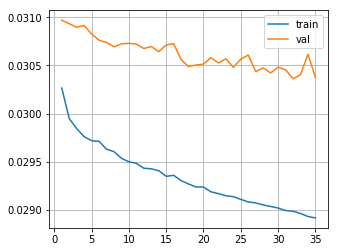

In [22]:
mt.plotHistory(training.history,size=(5,4),save="12/comb1/history.png")
mt.toCSV("12/comb1/history.csv",training.history)

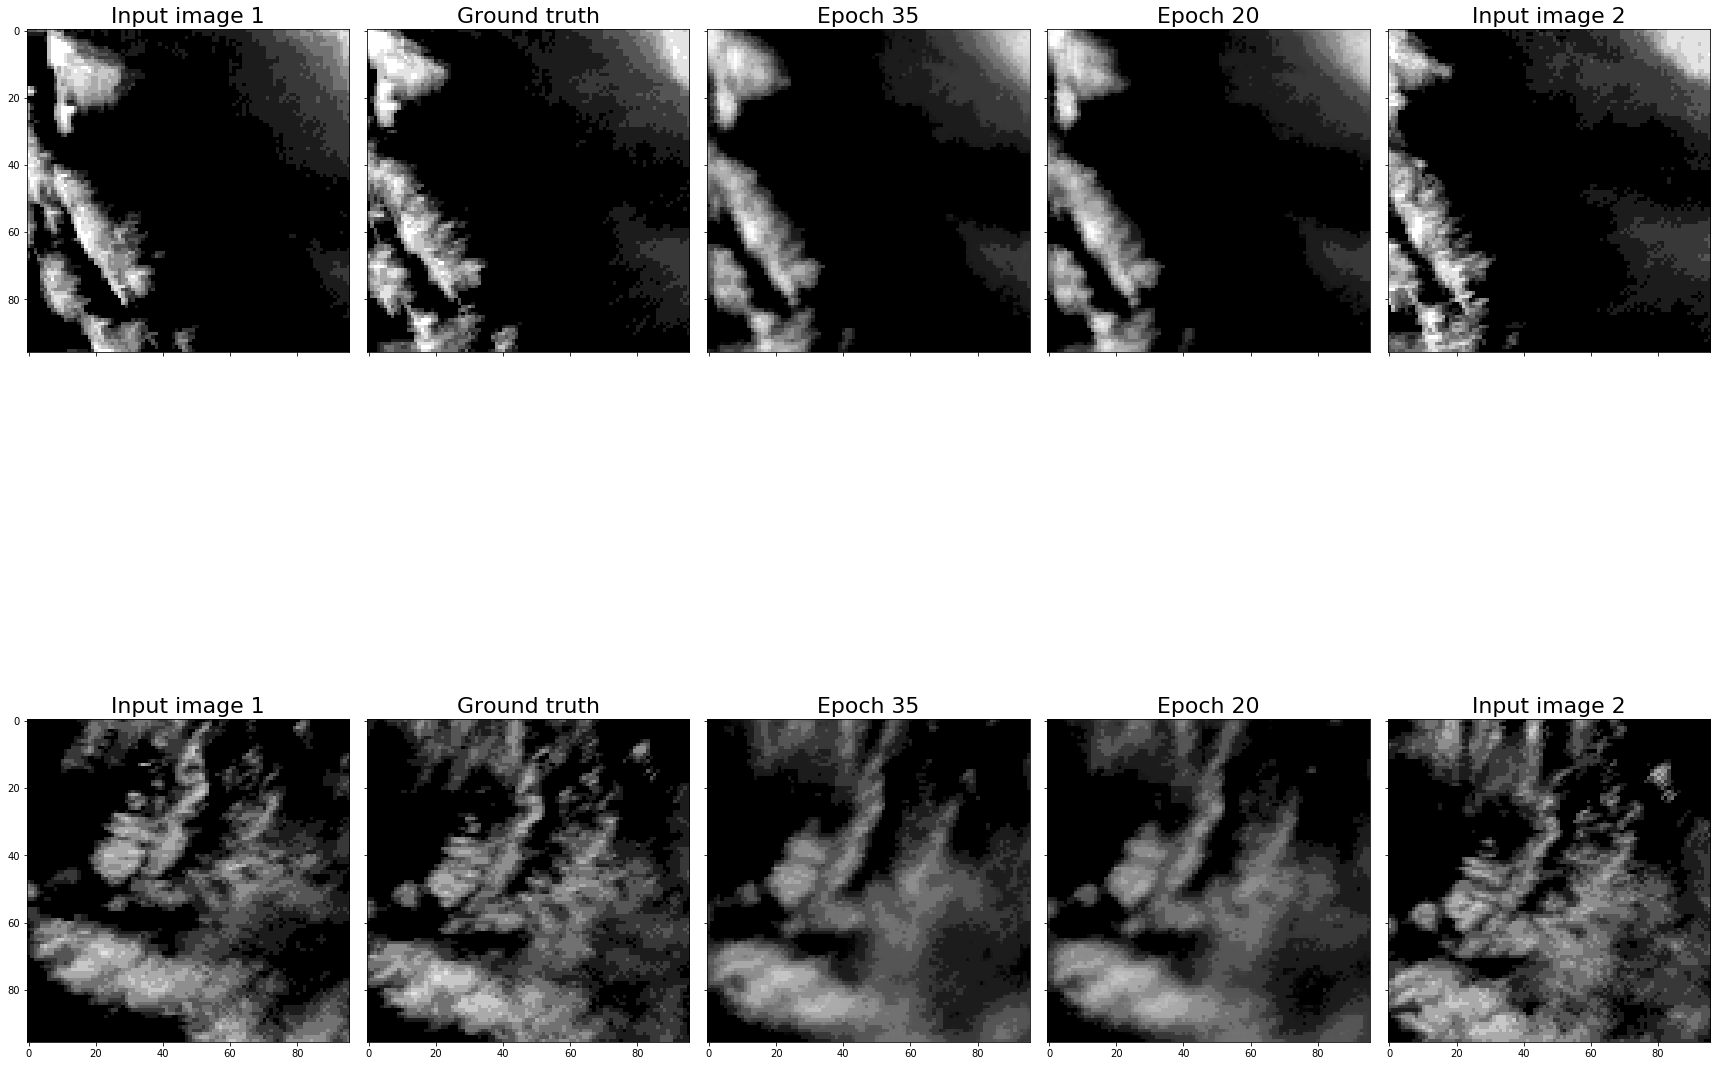

In [14]:
import matplotlib.pyplot as plt

# X = np.take(X_val,[13,38,42,82],axis=0)
# Y = np.take(y_val,[13,38,42,82],axis=0)
X = X_val[42:44]
Y = y_val[42:44]
model = Model()
model.load_state_dict(torch.load("12/comb1/weights35.pth"))
model.to(device)
out1 = model(torch.tensor(X, dtype=torch.float).to(device)).cpu().detach().numpy()
model.load_state_dict(torch.load("12/comb1/weights20.pth"))
out2 = model(torch.tensor(X, dtype=torch.float).to(device)).cpu().detach().numpy()

names = ['Input image 1','Ground truth','Epoch 35','Epoch 20','Input image 2']

COL = 5
fig, axes = plt.subplots(nrows=len(X), ncols=5, figsize=(24, 24),
                         sharex=True, sharey=True)
ax = axes.ravel()
for i in range(len(X)):
    ax[i*5].imshow(X[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    ax[i*5+1].imshow(Y[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    ax[i*5+2].imshow(out1[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    ax[i*5+3].imshow(out2[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    ax[i*5+4].imshow(X[i,1].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    
    ax[i*COL+0].set_title(names[0],fontsize=22)
    ax[i*COL+1].set_title(names[1],fontsize=22)
    ax[i*COL+2].set_title(names[2],fontsize=22)
    ax[i*COL+3].set_title(names[3],fontsize=22)
    ax[i*COL+4].set_title(names[4],fontsize=22)
    
plt.tight_layout()
plt.show()
# plt.savefig("12/comb1/example.png")

In [ ]:
import matplotlib.pyplot as plt

model = Model()
# Full showcase is [13,38,42,75,82]
X = np.take(X_val,[13,38,42,82],axis=0)
Y = np.take(y_val,[13,38,42,82],axis=0)
out = []

dic = mt.fromCSV("12/comb.csv")

# Get results of pure relu2_2
model.load_state_dict(torch.load("12/relu2_2/weights05.pth"))
out.append( model( torch.tensor(X, dtype=torch.float) ).cpu().detach().numpy() )

# Get results of combined
for name in dic['name']:
    model.load_state_dict(torch.load(name))#"12/" + name + "/weights05.pth"))
    out.append( model( torch.tensor(X, dtype=torch.float) ).cpu().detach().numpy() )

draw = [Y,*out]
names = ['Original image','relu2_2','Combined 0.00001','Combined 0.00002','Combined 0.00003']
ssims = [1,0.6670,*dic['ssim']]

COL = 5
fig, axes = plt.subplots(nrows=len(X), ncols=COL, figsize=(20, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()

# label = 'Average validation dataset SSIM: {:.4f}'
label = 'SSIM: {:.4f}'

for i in range(len(X)):
    for j in range(COL):
            ax[i*COL+j].imshow(draw[j][i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
            if i == len(X)-1:
                ax[i*COL+j].set_xlabel(label.format(ssims[j]),fontsize=22)
            if i == 0 :
                ax[i*COL+j].set_title(names[j],fontsize=22)

plt.tight_layout()
plt.show()

---------------------------------

In [ ]:
!cp weights1 gdrive/My\ Drive/12/5_transpose/weights
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/12/5_transpose/.

In [14]:
!zip fig.zip *.png
# !zip weights.zip weights*

updating: 00.png (deflated 3%)
updating: 01.png (stored 0%)
updating: 02.png (deflated 5%)
updating: 03.png (deflated 1%)
updating: 04.png (deflated 1%)
updating: 05.png (deflated 3%)
updating: 06.png (stored 0%)
updating: 07.png (deflated 2%)
updating: 08.png (deflated 2%)
updating: 09.png (deflated 2%)


In [ ]:
!cp fig.zip gdrive/My\ Drive/12/5_bilinear/.